In [ ]:
import sys
sys.path.append('/data/ECS/PythonTutorial/')
import log
log.topic_id = '29_OrnekProjeler-WebScraping'

# Web Scraping

Bu proje ile web'den düzenli olarak bir bilginin okunarak üzerinde ihtiyacımız olan işlemlerin yapılabilmesini sağlayacağız.

Hedef web sitemiz **sikayetvar.com**. Bu sitede yer alan Garanti BBVA şikayetlerini düzenli olarak okuyarak topladığımız verilerin üzerinde bazı işlemler yapacağız.

# Gerekli Kütüphaneler

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import locale
import datetime as dt
locale.setlocale(locale.LC_TIME, "tr_TR")


# İlk Sayfa

Sitenin Garanti BBVA ile ilgili şikayetlerin yer aldığı ilk sayfası **https://www.sikayetvar.com/garanti-bbva** adresinde yer alırken sonraki sayfalar için **https://www.sikayetvar.com/garanti-bbva?page=2** adresi kullanılıyor
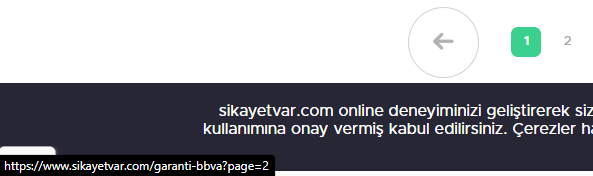

In [ ]:
url = "https://www.sikayetvar.com/garanti-bbva"

page = requests.get(url,
                    headers={'user-agent': 'ecs/0.0.1'},
                    proxies={"http":"http://tekprxv2:80", "https":"http://tekprxv2:80"},
                   )
page

# Parsing

Sorgulanan web sitesinden **<Response [200]>** soncunu almamız gerekiyor. Aksi taktirde bu siteye erişemiyor olduğumuz anlamına gelmektedir.

Siteye erişim sağladıktan sonra sitenin string şeklinde gelen içeriğini parse etmemiz gerekiyor. Bunun için bu örnekte **BeautifulSoup** kütüphanesini kullanıyor olacağız.

In [ ]:
soup = BeautifulSoup(page.content, "html.parser")
print(soup)

# Aradığımız içeriği bulma (Dikkat: html bilgisi gerektirir!)

web sitesinde ulaşmak istediğimiz içeriğin hangi web elemanı altında yer aldığı ve buna ne şekilde ulaşabiliyor olduğumuzu bilmemiz gerekmektedir. Bunun için de html doküman yapısına ve sorgu şekline aşina olmak gerekiyor.

Aşağıdaki örnekte şikayetlerin yer aldığı bileşenin **id="complaints"** olan bir **div** olduğunu görüyoruz. Bu elemanın altında her bir şikayet **article** tag'i ile sıralandığını görüyoruz.

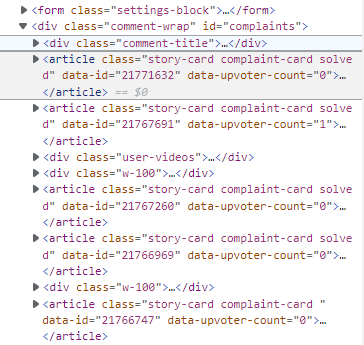

şimdi bunlardan bir tanesine ulaşıp içeriğini okuyalım

In [ ]:
complaints = soup.find(id="complaints")
complaints

In [ ]:
mesajlar = complaints.find_all('article', {'class':'complaint-card'})
mesajlar

## fonksiyon yap

In [ ]:
def sayfa_oku(p=None):
    if isinstance(p, type(None)):
        url = "https://www.sikayetvar.com/garanti-bbva"
    else:
        url = f"https://www.sikayetvar.com/garanti-bbva?page={p}"
        
    page = requests.get(url,
                        headers={'user-agent': 'ecs/0.0.1'},
                        proxies={"http":"http://tekprxv2:80", "https":"http://tekprxv2:80"},
                       )
    soup = BeautifulSoup(page.content, "html.parser")
    complaints = soup.find(id="complaints")
    mesajlar = complaints.find_all('article', {'class':'complaint-card'})
    
    return mesajlar

# Sayfadaki mesajları topla

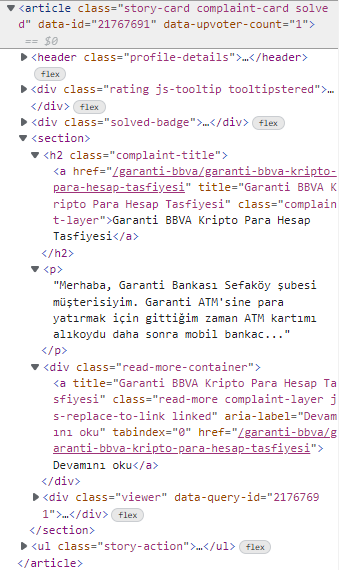

In [ ]:
mesaj = mesajlar[4]
mesaj_id = mesaj.attrs['data-id']
cozuldu = 'solved' in mesaj.attrs['class']
sikayetci = mesaj.find('header').find('a')['href']
rating = len(mesaj.find('div', {'class':'rating'}).find_all('img', {'alt':"tam yıldız"}))
konu = mesaj.find('section').find('h2').text
ozet = mesaj.find('section').find('p').text
devam_link = mesaj.find('div',{'class':'read-more-container'}).find('span').attrs['data-url']
mesaj_row = [mesaj_id, cozuldu, sikayetci, rating, konu, ozet, devam_link]
mesaj_row

In [ ]:
mesaj = mesajlar[10]
mesaj_id = mesaj.attrs['data-id']
cozuldu = 'solved' in mesaj.attrs['class']
sikayetci = mesaj.find('header').find('a')['href']
try:
    rating = len(mesaj.find('div', {'class':'rating'}).find_all('img', {'alt':"tam yıldız"}))
except:
    rating = -1
if isinstance(mesaj.find('section'), type(None)):
    konu = 'KALDIRILDI'
    ozet = ''
    devam_link = ''
else:
    konu = mesaj.find('section').find('h2').text    
    ozet = mesaj.find('section').find('p').text
    devam_link = mesaj.find('div',{'class':'read-more-container'}).find('span').attrs['data-url']
mesaj_row = [mesaj_id, cozuldu, sikayetci, rating, konu, ozet, devam_link]
mesaj_row

## fonksiyon yap

In [ ]:
def mesaj_formatla(mesaj):
    mesaj_id = mesaj.attrs['data-id']
    cozuldu = 'solved' in mesaj.attrs['class']
    sikayetci = mesaj.find('header').find('a')['href']
    try:
        rating = len(mesaj.find('div', {'class':'rating'}).find_all('img', {'alt':"tam yıldız"}))
    except:
        rating = -1
        
        
    tarih = mesaj.find('li',{'class':'js-tooltip'}).attrs['title']
    tarih = dt.datetime.strptime(tarih,'%d %B %H:%M')
    if tarih.year==1900:
        tarih = tarih.replace(year=dt.datetime.now().year)
    
    if isinstance(mesaj.find('section'), type(None)):
        konu = 'KALDIRILDI'
        ozet = ''
        devam_link = ''
    else:
        konu = mesaj.find('section').find('h2').text    
        ozet = mesaj.find('section').find('p').text
        devam_link = mesaj.find('div',{'class':'read-more-container'}).find('span').attrs['data-url']
    mesaj_row = [mesaj_id, tarih, cozuldu, sikayetci, rating, konu, ozet, devam_link]
    return mesaj_row    

mesaj_formatla(mesajlar[15])

## veritabanına kaydet

In [ ]:
import sqlite3

db_name = 'sikayetler.db'

def db_olustur(drop_table=False):
    conn = sqlite3.connect(db_name)    
    curr = conn.cursor()
    
    if drop_table:
        try:
            curr.execute("DROP TABLE SIKAYETLER")
        except:
            pass
    
    rows = curr.execute("SELECT name FROM sqlite_master WHERE type = 'table'")
    tablolar = [row[0] for row in rows]
    
    if not 'SIKAYETLER' in tablolar:
        sql = """
            create table SIKAYETLER (
                SIKAYET_ID int,
                ZAMAN datetime,
                COZULDU bool,
                SIKAYET_SAHIBI nvarchar(256),
                RATING int,
                KONU nvarchar(256),
                OZET nvarchar(256),
                DETAY_LINK nvarchar(256)
            )
        """
        curr = conn.cursor()
        curr.execute(sql)
        curr.close()
    conn.close()

def db_ekle(row):
    conn = sqlite3.connect(db_name)
    curr = conn.cursor()
    sql = """
        INSERT INTO 
        SIKAYETLER (SIKAYET_ID, ZAMAN, COZULDU, SIKAYET_SAHIBI, RATING, KONU, OZET, DETAY_LINK)
        VALUES (?,?,?,?,?,?,?,?)
    """
    curr.execute(sql, row)
    row_id = curr.lastrowid
    conn.commit()
    
    curr.close()
    conn.close()
    
    return row_id

db_olustur(drop_table=True)

In [ ]:
mesajlar = sayfa_oku(p=None)
for mesaj in mesajlar:
    row_id = db_ekle(mesaj_formatla(mesaj))
    print(row_id, end=',')

## 2-20 arasındaki sayfaları yükle

In [ ]:
for p in range(2,21):
    mesajlar = sayfa_oku(p=p)
    for mesaj in mesajlar:
        row_id = db_ekle(mesaj_formatla(mesaj))
        print(row_id, end=',')
    print(f'sayfa {p} tamamlandı')

# Kaydedilenleri Göster

In [ ]:
conn = sqlite3.connect(db_name)
df = pd.read_sql_query("SELECT * from SIKAYETLER", conn)
df

# Sonuçları İncele

In [ ]:
df = df.assign(GUN = pd.to_datetime(df.ZAMAN).dt.date)
df.head()

In [ ]:
df.groupby('GUN').apply(lambda x: pd.Series({
    'Şikayet Adet': len(x),
    'Çözümlenen': len(x[x.COZULDU==1]),
    'Kart': len(x[x.OZET.str.lower().str.contains('kart')]),
    'ATM': len(x[x.OZET.str.lower().str.contains('atm')]),
    'Şube': len(x[x.OZET.str.lower().str.contains('şube')]),
    'Şube': len(x[x.OZET.str.lower().str.contains('internet') |
                  x.OZET.str.lower().str.contains('ınternet') |
                  x.OZET.str.lower().str.contains('web') |
                  x.OZET.str.lower().str.contains('mobil') 
                 ]),
}))